In [1]:
import pandas as pd 
from pathlib import Path
data_folder = Path("data").resolve()



## Sanofi Assignment 

In [2]:
import pandas as pd

# Read the Excel file into a dictionary of dataframes
df_dict = pd.read_excel(data_folder / 'cc_Dataset.xlsx', sheet_name=['Sales 19-21', 'Sales 17-18', 'TV Spent', 'PromotionalEvents', 'OnsiteTrade'])

# Create a separate dataframe for each sheet_name in the dictionary
sales_19_21_df = df_dict['Sales 19-21']
sales_17_18_df = df_dict['Sales 17-18']
tv_spent_df = df_dict['TV Spent']
promo_events_df = df_dict['PromotionalEvents']
onsite_trade_df = df_dict['OnsiteTrade']


In [63]:
# Find out ranges of dates
print(f"Sales 17-18 min date: {sales_17_18_df['Date'].min()}")
print(f"Sales 17-18 max date: {sales_17_18_df['Date'].max()}")


print(f"Sales 19-21 min date: {sales_19_21_df['Date'].min()}")
print(f"Sales 19-21 max date: {sales_19_21_df['Date'].max()}")


print(f"TV SPENT min date: {tv_spent_df['Date'].min()}")
print(f"TV SPENT max date: {tv_spent_df['Date'].max()}")


print(f"Promotional Events min date: {promo_events_df['Date'].min()}")
print(f"Promotional Events max date: {promo_events_df['Date'].max()}")

print(f"Onsite Trade min date: {onsite_trade_df['Date'].min()}")
print(f"Onsite Trade max date: {onsite_trade_df['Date'].max()}")


Sales 17-18 min date: 2017-01-01 00:00:00
Sales 17-18 max date: 2018-12-01 00:00:00
Sales 19-21 min date: 2019-01-07 00:00:00
Sales 19-21 max date: 2021-07-12 00:00:00
TV SPENT min date: 2019-01-07 00:00:00
TV SPENT max date: 2021-07-12 00:00:00
Promotional Events min date: 2017-02-01 00:00:00
Promotional Events max date: 2021-12-01 00:00:00
Onsite Trade min date: 2017-01-01 00:00:00
Onsite Trade max date: 2020-12-01 00:00:00


In [3]:
# Concat sales into one dataframe
sales_frames = [sales_17_18_df, sales_19_21_df]
sales = pd.concat(sales_frames)

In [65]:
print(f"Sales data min date: {sales['Date'].min()}")
print(f"Sales data max date: {sales['Date'].max()}")

Sales data min date: 2017-01-01 00:00:00
Sales data max date: 2021-07-12 00:00:00


In [4]:
# Sort by date 
sales = sales.sort_values(by='Date')

In [5]:
sales.rename(columns={'Value': 'sales'}, inplace=True)

In [68]:
# Rename some column in tv promotional adds
tv_spent_df = tv_spent_df.rename(columns={'Channel 1': 'tv_channel_1', 
'Channel 2': 'tv_channel_2', 'Channel 3':'tv_channel_3'})



In [69]:
# Merge the TV spending data with the sales data
sales_tv_spent = pd.merge(sales, tv_spent_df, on='Date')

# Merge the promotional events data with the sales data
sales_promo_events = pd.merge(sales, promo_events_df, on='Date')

# Merge the trade marketing data with the sales data
sales_onsite_trade = pd.merge(sales, onsite_trade_df, on='Date')

In [70]:
# Rename for more redability
sales_onsite_trade = sales_onsite_trade.rename(columns={'Value':'Cost'})

In [84]:
import numpy as np
def calculate_roi(sales_tv_spent, sales_promo_events, sales_onsite_trade):
    # Calculate the total TV spending
    tv_spending = sales_tv_spent['tv_channel_1'] + sales_tv_spent['tv_channel_2'] + sales_tv_spent['tv_channel_3']
    
    # Calculate the ROI for each TV channel
    sales_tv_spent['TV_Channel_1_ROI'] = (sales_tv_spent.sales * sales_tv_spent['tv_channel_1']) / np.where(tv_spending == 0, 1, tv_spending)
    sales_tv_spent['TV_Channel_2_ROI'] = (sales_tv_spent.sales * sales_tv_spent['tv_channel_2']) / np.where(tv_spending == 0, 1, tv_spending)
    sales_tv_spent['TV_Channel_3_ROI'] = (sales_tv_spent.sales * sales_tv_spent['tv_channel_3']) / np.where(tv_spending == 0, 1, tv_spending)
    
    # Calculate the total ROI for all TV channel investments
    sales_tv_spent['TV_ROI'] = sales_tv_spent.sales / np.where(tv_spending == 0, 1, tv_spending)
    
    # Group the data by Topic and calculate the ROI
    grouped_promo_events = sales_promo_events.groupby(['Topic', 'Date']).agg({'sales': 'sum', 'Cost': 'sum'})

    grouped_promo_events['ROI'] = (grouped_promo_events['sales'] - grouped_promo_events['Cost']) / grouped_promo_events['Cost']
    grouped_promo_events = grouped_promo_events.reset_index()
    

    # Group the data by Region and calculate the ROI
    grouped_promo_events_region = sales_promo_events.groupby(['Region', 'Date']).agg({'sales': 'sum', 'Cost': 'sum'})
    grouped_promo_events_region['ROI'] = (grouped_promo_events_region['sales'] - grouped_promo_events_region['Cost']) / grouped_promo_events_region['Cost']
    grouped_promo_events_region = grouped_promo_events_region.reset_index()

    
    # Group the data by Region and calculate the ROI
    grouped_onsite_trade = sales_onsite_trade.groupby(['Region', 'Date']).agg({'sales': 'sum', 'Cost': 'sum'})
    
    # Drop the rows where 'Cost' is 0
    grouped_onsite_trade = grouped_onsite_trade[grouped_onsite_trade['Cost'] != 0]
    
    # Calculate the ROI
    grouped_onsite_trade['ROI'] = (grouped_onsite_trade['sales'] - grouped_onsite_trade['Cost']) / grouped_onsite_trade['Cost']
    grouped_onsite_trade = grouped_onsite_trade.reset_index()
    
    return sales_tv_spent, grouped_promo_events, grouped_promo_events_region, grouped_onsite_trade


In [85]:
sales_tv_spent, grouped_promo_events, grouped_promo_events_region, grouped_onsite_trade = calculate_roi(sales_tv_spent, sales_promo_events, sales_onsite_trade)

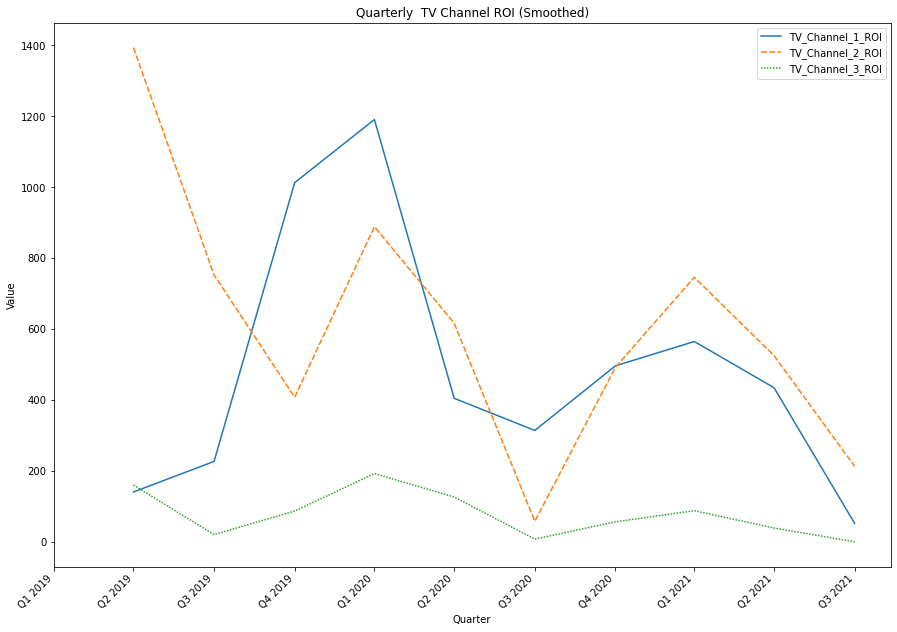

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

sales_tv_spent_date = sales_tv_spent.set_index('Date')
sales_tv_spent_date_q = sales_tv_spent_date.resample('Q').mean()

# Smooth the lines by calculating a rolling average with window size 2 quarters
sales_tv_spent_date_q_smoothed = sales_tv_spent_date_q.rolling(window=2).mean()

# Create the line plot with smoothed data
plt.figure(figsize=(15, 10))
sns.lineplot(data=sales_tv_spent_date_q_smoothed[[ 'TV_Channel_1_ROI', 'TV_Channel_2_ROI', 'TV_Channel_3_ROI']])

# Set the tick labels for the x-axis
tick_labels = [f'Q{q.quarter} {q.year}' for q in sales_tv_spent_date_q_smoothed.index]
plt.xticks(sales_tv_spent_date_q_smoothed.index, tick_labels, rotation=45, ha='right')

# Add labels and title to the plot
plt.xlabel('Quarter')
plt.ylabel('Value')
plt.title('Quarterly  TV Channel ROI (Smoothed)')

# Display the plot
plt.show()


In [87]:
# sales promotional events 

sales_promo_events.head()

,Date,sales,Topic,Region,Target,Cost,Participants
0,2017-02-01,56386.69830,C&C,PARIS,GENERAL,24.881,523
1,2017-02-01,56386.69830,C&C,PARIS,PHYSICIANS,15.634,375
2,2017-02-01,56386.69830,COUGH,PARIS,PHYSICIANS,23.505,494
3,2017-05-01,32764.04252,C&C,PARIS,PHYSICIANS,11.039,298
4,2017-05-01,32764.04252,PULMONAR,PARIS,GENERAL,17.069,410


In [88]:
sales_promo_events.sort_values(by ='Cost')

,Date,sales,Topic,Region,Target,Cost,Participants
49,2018-09-01,52670.045106,COUGH,TOULOUSE,PHYSICIANS,10.475,31
59,2018-12-01,82616.154802,SOAR THROAT,PARIS,PHYSICIANS,10.996,99
3,2017-05-01,32764.042520,C&C,PARIS,PHYSICIANS,11.039,298
12,2018-01-01,84592.519326,COUGH,MARSEILLE,GENERAL,11.493,80
14,2018-01-01,84592.519326,COUGH,MARSEILLE,PHYSICIANS,11.842,71
...,...,...,...,...,...,...,...
11,2017-09-01,55884.359040,PULMONAR,OTHER,PHARMACIES,29.485,59
40,2018-06-01,26147.977383,C&C,PARIS,PHARMACIES,29.592,266
26,2018-02-01,77662.014620,C&C,MARSEILLE,PHARMACIES,29.827,89
65,2019-07-01,1038.626315,COUGH,OTHER,PHARMACIES,29.843,239


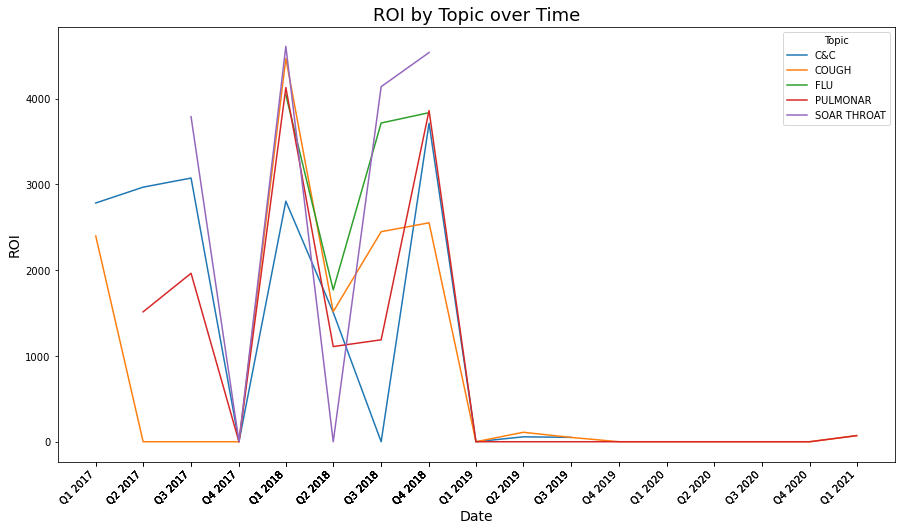

In [89]:
grouped_promo_events.set_index('Date', inplace=True)
grouped_promo_events_m = grouped_promo_events.groupby('Topic').resample('Q').mean()


# Apply the rolling window to the ROI column

grouped_promo_events_m = grouped_promo_events_m.fillna(0)
# Reset the index of the DataFrame
grouped_promo_events_m.reset_index(inplace=True)

# Create a line plot for each topic with the ROI on the y-axis and the date on the x-axis
plt.figure(figsize=(15, 8))
g = sns.lineplot(x='Date', y='ROI', hue='Topic', data=grouped_promo_events_m)

# Set the tick labels for the x-axis
grouped_promo_events_m.set_index('Date', inplace=True)
tick_labels = [f'Q{q.quarter} {q.year}' for q in grouped_promo_events_m.index]
plt.xticks(grouped_promo_events_m.index, tick_labels, rotation=45, ha='right')
# Set the x-axis label
g.set_xlabel('Date', fontsize=14)

# Set the y-axis label
g.set_ylabel('ROI', fontsize=14)

# Set the title of the plot
g.set_title('ROI by Topic over Time', fontsize=18)

# Show the plot
plt.show()

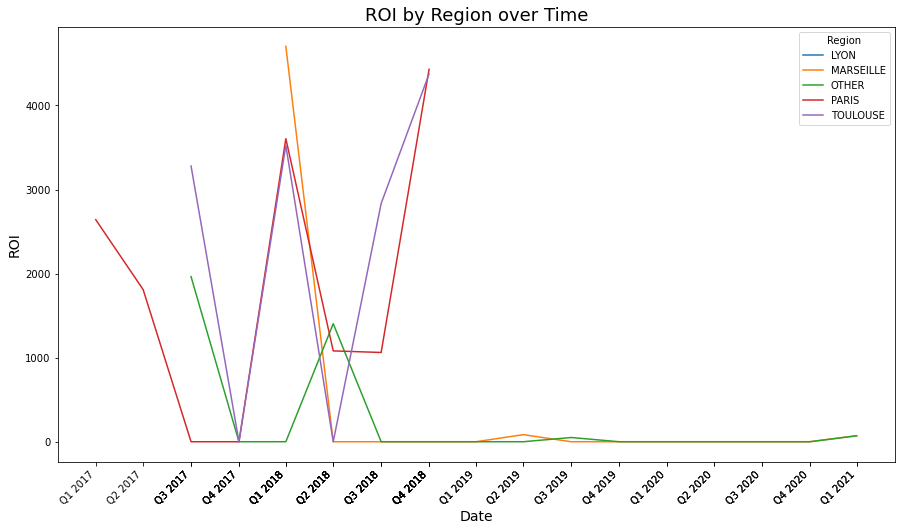

In [81]:
#grouped_promo_events_region.set_index('Date', inplace=True)
grouped_promo_events_region_q = grouped_promo_events_region.groupby('Region').resample('Q').mean()


# Apply the rolling window to the ROI column

grouped_promo_events_region_q = grouped_promo_events_region_q.fillna(0)
# Reset the index of the DataFrame
grouped_promo_events_region_q.reset_index(inplace=True)

# Create a line plot for each topic with the ROI on the y-axis and the date on the x-axis
plt.figure(figsize=(15, 8))
g = sns.lineplot(x='Date', y='ROI', hue='Region', data=grouped_promo_events_region_q)

# Set the tick labels for the x-axis
grouped_promo_events_region_q.set_index('Date', inplace=True)
tick_labels = [f'Q{q.quarter} {q.year}' for q in grouped_promo_events_region_q.index]
plt.xticks(grouped_promo_events_region_q.index, tick_labels, rotation=45, ha='right')
# Set the x-axis label
g.set_xlabel('Date', fontsize=14)

# Set the y-axis label
g.set_ylabel('ROI', fontsize=14)

# Set the title of the plot
g.set_title('ROI by Region over Time', fontsize=18)

# Show the plot
plt.show()

In [83]:
grouped_onsite_trade

sales     Cost         ROI
Region     Date                                          
ATLANTIQUE 2017-01-01  166512.588828  1583.40  104.161418
           2017-02-01  112773.396600  1188.30   93.903136
           2017-03-01   87145.847204  2182.88   38.922418
           2017-09-01  111768.718080  1205.40   91.723343
           2017-10-01  118376.180480  1092.25  107.378284
...                              ...      ...         ...
PARIS      2018-03-01   53630.379705  1782.00   29.095612
           2018-09-01   52670.045106  1479.00   34.611930
           2018-10-01   56044.435179  1288.00   42.512760
           2018-11-01   73438.949381  1577.00   45.568769
           2018-12-01   82616.154802  1263.00   64.412632

[70 rows x 3 columns]

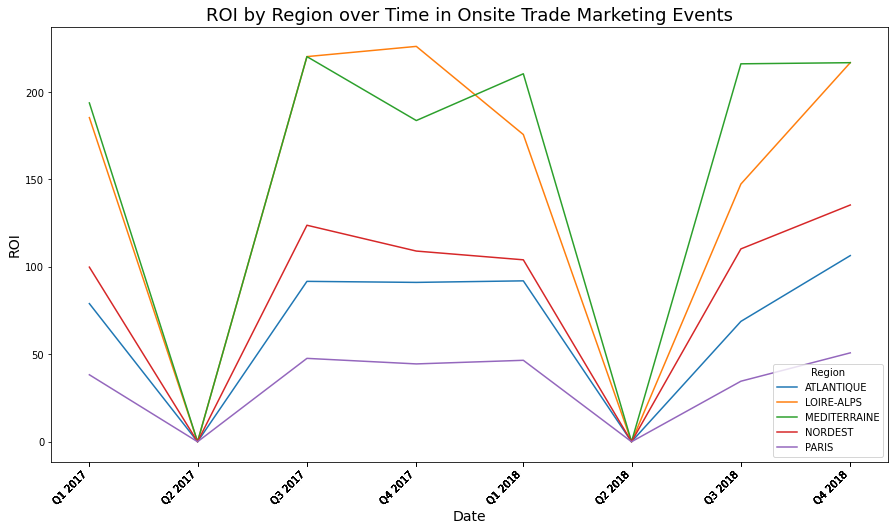

In [90]:

grouped_onsite_trade.set_index('Date', inplace=True)

grouped_onsite_trade_q = grouped_onsite_trade.groupby('Region').resample('Q').mean()



grouped_onsite_trade_q = grouped_onsite_trade_q.fillna(0)
# Reset the index of the DataFrame
grouped_onsite_trade_q.reset_index(inplace=True)

# Create a line plot for each topic with the ROI on the y-axis and the date on the x-axis
plt.figure(figsize=(15, 8))
g = sns.lineplot(x='Date', y='ROI', hue='Region', data=grouped_onsite_trade_q)

# Set the tick labels for the x-axis
grouped_onsite_trade_q.set_index('Date', inplace=True)
tick_labels = [f'Q{q.quarter} {q.year}' for q in grouped_onsite_trade_q.index]
plt.xticks(grouped_onsite_trade_q.index, tick_labels, rotation=45, ha='right')
# Set the x-axis label
g.set_xlabel('Date', fontsize=14)

# Set the y-axis label
g.set_ylabel('ROI', fontsize=14)

# Set the title of the plot
g.set_title('ROI by Region over Time in Onsite Trade Marketing Events', fontsize=18)

# Show the plot
plt.show()




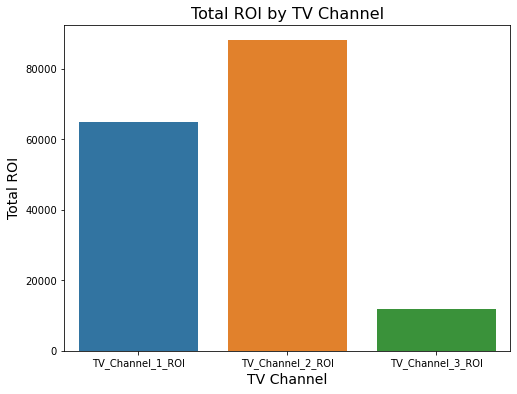

In [91]:
# Calculate total ROI for each TV channel
total_tv_roi = sales_tv_spent[['TV_Channel_1_ROI', 'TV_Channel_2_ROI','TV_Channel_3_ROI' ]].sum()

# Create a bar plot to compare ROI for each channel
plt.figure(figsize=(8,6))
sns.barplot(x=total_tv_roi.index, y=total_tv_roi.values)
plt.title('Total ROI by TV Channel', fontsize=16)
plt.xlabel('TV Channel', fontsize=14)
plt.ylabel('Total ROI', fontsize=14)
plt.show()


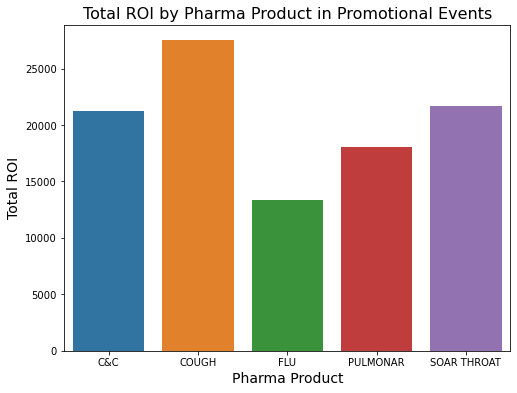

In [92]:
# Calculate total ROI for each pharma product
total_product_roi = grouped_promo_events.groupby('Topic')['ROI'].sum()

# Create a bar plot to compare ROI for each product
plt.figure(figsize=(8,6))
sns.barplot(x=total_product_roi.index, y=total_product_roi.values)
plt.title('Total ROI by Pharma Product in Promotional Events', fontsize=16)
plt.xlabel('Pharma Product', fontsize=14)
plt.ylabel('Total ROI', fontsize=14)
plt.show()


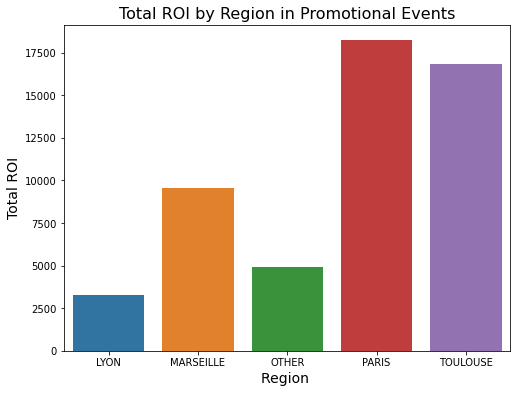

In [93]:
# Calculate total ROI for each pharma product
total_region_promo_event_roi = grouped_promo_events_region.groupby('Region')['ROI'].sum()

# Create a bar plot to compare ROI for each product
plt.figure(figsize=(8,6))
sns.barplot(x=total_region_promo_event_roi.index, y=total_region_promo_event_roi.values)
plt.title('Total ROI by Region in Promotional Events', fontsize=16)
plt.xlabel('Region ', fontsize=14)
plt.ylabel('Total ROI', fontsize=14)
plt.show()

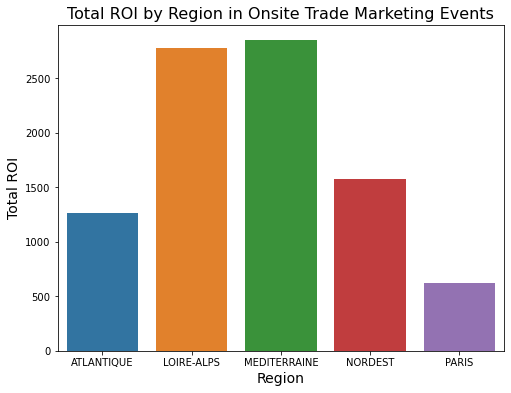

In [94]:
# Calculate total ROI for each region
total_region_roi = grouped_onsite_trade.groupby('Region')['ROI'].sum()

# Create a bar plot to compare ROI for each region
plt.figure(figsize=(8,6))
sns.barplot(x=total_region_roi.index, y=total_region_roi.values)
plt.title('Total ROI by Region in Onsite Trade Marketing Events', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total ROI', fontsize=14)
plt.show()


/Users/servandodavidtorresgarcia/miniconda3/envs/prophet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
20:30:20 - cmdstanpy - INFO - Chain [1] start processing
20:30:20 - cmdstanpy - INFO - Chain [1] done processing


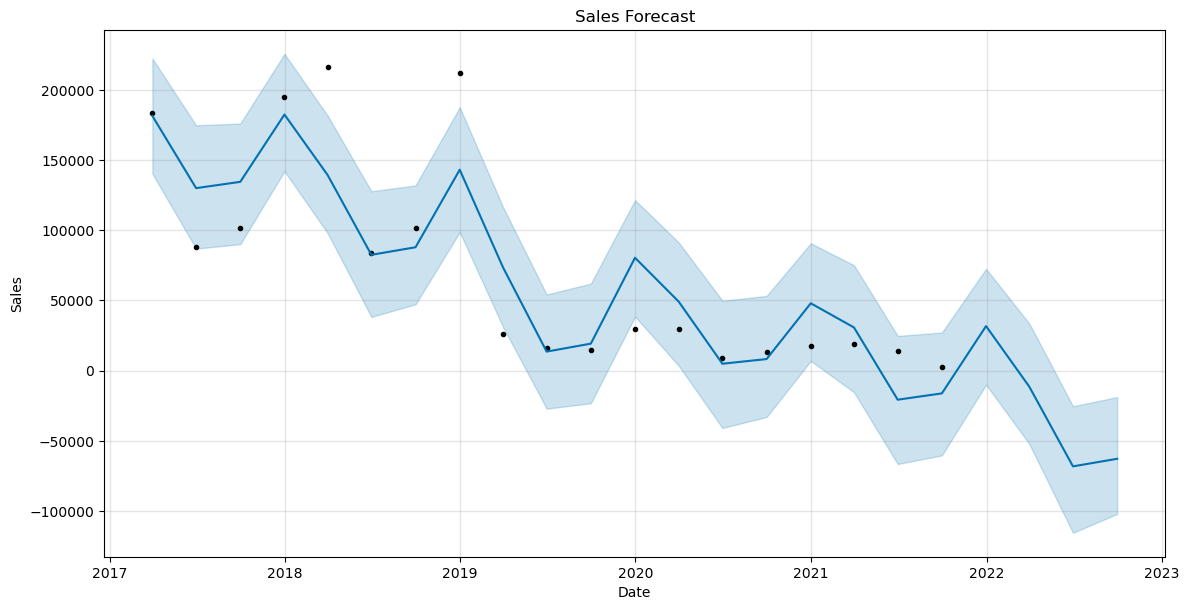

In [6]:
# Forecast sales


import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Rename columns to ds and y for Prophet
sales_forecast = sales.rename(columns={'Date': 'ds', 'sales': 'y'})

# Set the frequency to quarterly
sales_forecast = sales_forecast.set_index('ds').resample('Q').sum().reset_index()

# Create a Prophet model
m = Prophet()
# Add quarterly seasonality
m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5)

# Fit the model on the sales data
m.fit(sales_forecast)

# Create a future dataframe with quarterly frequency for the next 4 quarters
future = m.make_future_dataframe(periods=4, freq='Q')

# Predict the sales for the future dataframe
forecast = m.predict(future)


# Plot the forecasted sales with upper and lower bounds
fig, ax = plt.subplots(figsize=(12, 6))
fig = m.plot(forecast, ax=ax)


# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales')

# Set the title of the plot
plt.title('Sales Forecast')

# Show the plot
plt.show()


Based on our analysis of the CC dataset, we have identified several key findings that are relevant for executives to consider when making strategic decisions for Sanofi:

- **Firstly**, we found that the best quarters for TV promotions were late Q3 2019 and beginning Q2 2020, while the worst quarter for all TV promotion channels was Q3 2020. Furthermore, while TV channel number 1 had the highest ROI during this period, it experienced a significant fall during Q3 2020. Channel number 2 surpassed channel number 1 during 2021, and all three channels saw a decline in Q3 2021.

- **Secondly**, promotional events performed poorly for all products starting in Q1 2019, with the highest ROI for almost all products being in Q1 2018. This trend was also observed in different regions. Trade marketing events saw two major falls in Q2 2017 and Q2 2018, with the Mediterranean and Loire-Alps regions showing better ROI performance.

- **Lastly**, based on historical data, our forecasting model predicts a dramatic fall for 2023, indicating a trend of decreasing sales.

- In light of these findings, we recommend that Sanofi allocate resources towards TV ads and marketing campaigns for cough products and the France region, as these are the biggest revenue generators. However, given the trend of decreasing sales, Sanofi may also need to consider redirecting resources towards more targeted marketing campaigns or consider a customer segmentation strategy to better target its audience.

- Furthermore, exploring social media outreach to attract more buyers and enhance the sales experience between sales reps and health physicians may also be worth considering. Overall, we believe that by taking these recommendations into account, Sanofi can make informed decisions to optimize their marketing strategies and maintain their competitive edge in the pharmaceutical industry.